In [1]:
%load_ext autoreload
%autoreload

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Reshape,Flatten,UpSampling2D,concatenate, Activation

import numpy as np
import matplotlib.pyplot as plt

from constants import INPUT_SHAPE, class2label
from conversion import get_class2color, FloorplanRaw, FloorplanSVG, read_room2class_condensed

## Problem Definition

## Exploratory Data Analysis

## Wall Prediction

## Room Type Prediction

Our room type prediction model takes in a floorplan image and produces a semantic map where each pixel is assigned a class indicating its room type or being not a room.

We group the room types into 7 major categories:

In [9]:
# Mappings between room type, class label, and color for visualization
room2class = read_room2class_condensed("room_types_succinct.txt")
class2room = {v: k for k, v in room2class.items()}
class2color = get_class2color(max(room2class.values())+1)
n_classes = max(room2class.values())+1

print(list(class2label.values()))

['Empty', 'Entry', 'Outdoor', 'Bathroom', 'Kitchen', 'Livingroom', 'Bedroom', 'Others']


The input image is the same as in the model for wall prediction, while we extract the room type target semantic map from the `svg` file as a preprocessing step. The pipeline for this is as follows:

1. Create a blank 2D array of the same shape as the input image (256 x 256), which we refer to as the semantic map.
2. Read the polygon shapes of each room from the svg file.
3. Fill the pixels in the semantic map with the class labels of each polygon.
4. Apply `to_categorical` to the semantic map to expand it into a 3D array for classification training.


The semantic map of an example floor plan is shown below, overlayed on the input image.

In [10]:
# Load data
dataset_dir = "./data/cubicasa5k"

train_X = np.load(dataset_dir + "/train_inputs.npy")
train_y = np.load(dataset_dir + "/train_labels.npy")
train_y = to_categorical(train_y, num_classes=n_classes, dtype=np.int8)
val_X = np.load(dataset_dir + "/val_inputs.npy")
val_y = np.load(dataset_dir + "/val_labels.npy")
val_y = to_categorical(val_y, num_classes=n_classes, dtype=np.int8)

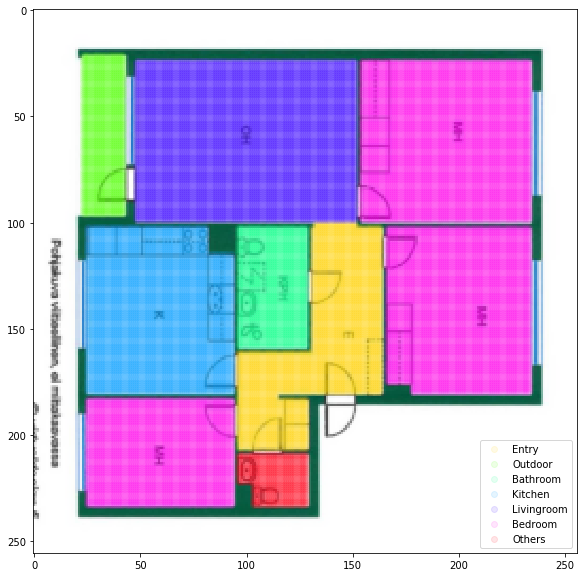

In [12]:
idx = 5
input_example = val_X[idx]
label_example = val_y[idx]
FloorplanSVG.show_map(np.argmax(label_example, axis=-1), input_example, class2color, class2room)

The neural network model is very similar to the one for the wall prediction (U-net) except for the linear activation for the 2nd-to-last layer, and that last layer produces an array with n_classes channels.

In [16]:
# Neural network model for room type prediction
input_layer = Input(shape=INPUT_SHAPE)

#encoder
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
conv1 = Dropout(0.2)(conv1)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Dropout(0.2)(conv2)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D((2, 2))(conv2)

#decoder
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Dropout(0.2)(conv3)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

up1 = concatenate([UpSampling2D((2, 2))(conv3), conv2], axis=-1)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
conv4 = Dropout(0.2)(conv4)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)

up2 = concatenate([UpSampling2D((2, 2))(conv4), conv1], axis=-1)
conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
conv5 = Dropout(0.2)(conv5)
conv5 = Conv2D(32, (3, 3), activation='linear', padding='same')(conv5)


out = Conv2D(n_classes, (1, 1) , padding='same', activation=tf.nn.softmax)(conv5)


model = Model(input_layer ,out, name = 'U-net')

loss = tf.keras.losses.categorical_crossentropy
opt = Adam(lr = 0.001)
model.compile(loss= loss, optimizer=opt, metrics = ['accuracy'])
model.summary()

Model: "U-net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 256, 256, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 256, 256, 32) 0           conv2d_11[0][0]                  
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 256, 256, 32) 9248        dropout_5[0][0]                  
______________________________________________________________________________________________

In [17]:
model.load_weights("room_type_model_weights.h5")

After training for ~70 epochs, we achieved an accuracy of ~0.63 on the validation set. 

The output for the above example input is shown below:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


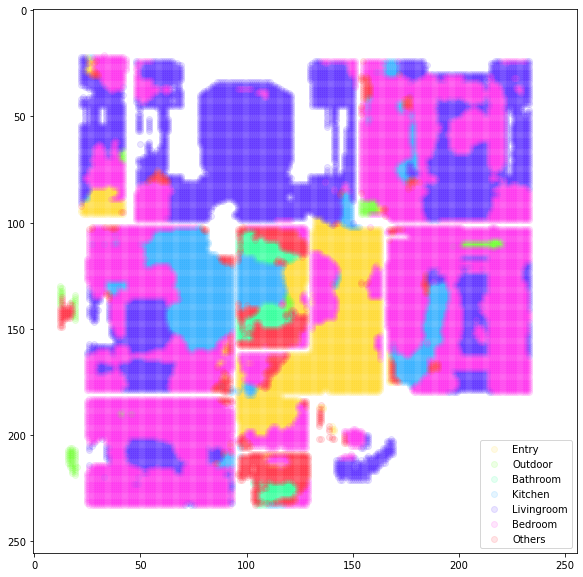

In [18]:
trial = val_X[idx]
result = model.predict(np.expand_dims(trial, axis=0))[0]
FloorplanSVG.show_map(np.argmax(result, axis=-1), 255*np.ones_like(trial), class2color, class2room)

The above result shows that the overall floor plan structures have been recovered and the room types have been identified yet they are sometimes inconsistent within each room, which brings us to the next section.

## Innovation - Room Type Consistency

## Future Work